In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import math
import torch.nn as nn
import numpy as np

In [3]:

b_j0 = .1  # neural threshold baseline
R_m = 3  # membrane resistance
dt = 1
gamma = .5  # gradient scale
lens = 0.5

def gaussian(x, mu=0., sigma=.5):
    return torch.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) / torch.sqrt(2 * torch.tensor(math.pi)) / sigma


class ActFun_adp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):  # input = membrane potential- threshold
        ctx.save_for_backward(input)
        return input.gt(0).float()  # is firing ???

    @staticmethod
    def backward(ctx, grad_output):  # approximate the gradients
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        # temp = abs(input) < lens
        scale = 6.0
        hight = .15
        # temp = torch.exp(-(input**2)/(2*lens**2))/torch.sqrt(2*torch.tensor(math.pi))/lens
        temp = gaussian(input, mu=0., sigma=lens) * (1. + hight) \
               - gaussian(input, mu=lens, sigma=scale * lens) * hight \
               - gaussian(input, mu=-lens, sigma=scale * lens) * hight
        # temp =  gaussian(input, mu=0., sigma=lens)
        return grad_input * temp.float() * gamma
        # return grad_input

act_fun_adp = ActFun_adp.apply

def mem_update_adp(inputs, mem, spike, tau_adp,tau_m, b, dt=1, isAdapt=1):
    # computation of exp is outside of this function
    alpha = tau_m

    ro = tau_adp

    if isAdapt:
        beta = 1.8
    else:
        beta = 0.

    # adaptive contribution, decays with tau_adp, also dependent on spike
    b = ro * b + (1 - ro) * spike
    # compute current adapted threshold
    B = b_j0 + beta * b

    #
    d_mem = -mem + inputs
    mem = mem + d_mem*alpha
    # diff between adapted threshold and current mem
    inputs_ = mem - B

    spike = act_fun_adp(inputs_)  # act_fun : approximation firing function
    # hard mem potential resetting if spiked
    mem = (1-spike)*mem

    return mem, spike, B, b

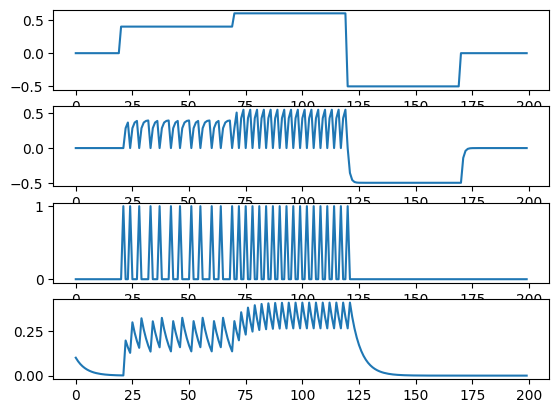

In [4]:
# simulate one LIF with fixed time constants neuron
# num of time steps of simulation
T = torch.arange(0, 200)
# initial tau
tau_m = np.exp(-1*dt/3)
tau_adp =  np.exp(-1*dt/4.6)
mem_hist = torch.zeros(len(T)+1)
mem_hist[0] = 0
spike_hist = torch.zeros(len(T)+1)
spike_hist[0] = 0
adp_thre_hist = torch.zeros(len(T)+1)
adp_thre_hist[0] = b_j0
# set up input current
inputCurrent = torch.concatenate([torch.zeros(20), torch.full(size=[50], fill_value=0.4), torch.full(size=[50], fill_value=0.6), torch.full(size=[50], fill_value=-0.5), torch.zeros(30)])
for t in T:
    mem_hist[t+1], spike_hist[t+1], _, adp_thre_hist[t+1] = mem_update_adp(inputCurrent[t], mem_hist[t], spike_hist[t], tau_adp, tau_m, adp_thre_hist[t])

fig, axes = plt.subplots(4, 1)
axes[0].plot(T, inputCurrent)
axes[1].plot(T, mem_hist[:200])
axes[2].plot(T, spike_hist[:200])
axes[3].plot(T, adp_thre_hist[:200])
plt.show()

# Compare LTC and non LTC (not recurrent)

In [146]:
###############################################################################################
###############################################################################################
###############################################################################################
class SNN_rec_cell(nn.Module):
    def __init__(self, input_size, hidden_size,is_rec = False,is_LTC=True):
        super(SNN_rec_cell, self).__init__()


        self.input_size = input_size
        self.hidden_size = hidden_size
        self.is_rec = is_rec
        self.is_LTC = is_LTC

        if is_rec:
            self.layer1_x = nn.Linear(input_size+hidden_size, hidden_size)
        else:
            self.layer1_x = nn.Linear(input_size, hidden_size)

        # time-constant definiation and initilization
        if is_LTC:
            self.layer1_tauAdp = nn.Linear(2*hidden_size, hidden_size)
            self.layer1_tauM = nn.Linear(2*hidden_size, hidden_size)
            nn.init.xavier_uniform_(self.layer1_tauAdp.weight)
            nn.init.xavier_uniform_(self.layer1_tauM.weight)
        else:
            self.tau_adp = nn.Parameter(torch.Tensor(hidden_size))
            self.tau_m =nn.Parameter(torch.Tensor(hidden_size))
            nn.init.normal_(self.tau_adp, 4.6,.1)
            nn.init.normal_(self.tau_m, 3.,.1)
        self.act1 = nn.Sigmoid()
        self.act2 = nn.Sigmoid()

        nn.init.xavier_uniform_(self.layer1_x.weight)


    def forward(self, x_t, mem_t,spk_t,b_t):
        if self.is_rec:
            dense_x = self.layer1_x(torch.cat((x_t,spk_t),dim=-1))
        else:
            dense_x = self.layer1_x(x_t)

        if self.is_LTC:
            tauM1 = self.act1(self.layer1_tauM(torch.cat((dense_x,mem_t),dim=-1))) #*0.1+0.5
            tauAdp1 = self.act1(self.layer1_tauAdp(torch.cat((dense_x,b_t),dim=-1))) #*0.1+0.5
        else:
            tauM1 = self.act1(self.tau_m) #*0.1+0.5
            tauAdp1 = self.act2(self.tau_adp) #*0.1+0.5

        mem_1,spk_1,_,b_1 = mem_update_adp(dense_x, mem=mem_t,spike=spk_t,
                                        tau_adp=tauAdp1,tau_m=tauM1,b =b_t)

        return mem_1,spk_1,b_1

    def compute_output_size(self):
        return [self.hidden_size]

In [ ]:
def true_tau(x): # sigmoid(x) => exp(-1/tau)

In [147]:
input_size = 10
output_size = 10
LTC = SNN_rec_cell(input_size, output_size, is_rec=False, is_LTC=True)
non_LTC = SNN_rec_cell(input_size, output_size, is_rec=False, is_LTC=False)

In [109]:
LTC

SNN_rec_cell(
  (layer1_x): Linear(in_features=10, out_features=10, bias=True)
  (layer1_tauAdp): Linear(in_features=20, out_features=10, bias=True)
  (layer1_tauM): Linear(in_features=20, out_features=10, bias=True)
  (act1): Sigmoid()
  (act2): Sigmoid()
)

In [31]:
non_LTC

SNN_rec_cell(
  (layer1_x): Linear(in_features=10, out_features=10, bias=True)
  (act1): Sigmoid()
  (act2): Sigmoid()
)

In [118]:
current = torch.concatenate((torch.full((50, 10), fill_value=0), torch.full((75, 10), fill_value=0.2), torch.full((75, 10), fill_value=0.05))) # batch size second

def simulate(ltc=True):
    mems = []
    spks = []
    thresholds = []

    mem_, spk_, thre_ = torch.zeros(10), torch.zeros(10), torch.zeros(10)
    for t in range(200):
        if ltc:
            mem_, spk_, thre_ = LTC(current[t, :], mem_, spk_, thre_)
        else:
            mem_, spk_, thre_ = non_LTC(current[t, :], mem_, spk_, thre_)


        mems.append(mem_.detach())
        spks.append(spk_.detach())
        thresholds.append(thre_.detach())

    mems = torch.vstack(mems)
    spks = torch.vstack(spks)
    thresholds = torch.vstack(thresholds)

    return mems, spks, thresholds


In [148]:
LTC_mems, LTC_spks, LTC_thre = simulate()
nonLTC_mems, nonLTC_spks, nonLTC_thre = simulate(ltc=False)

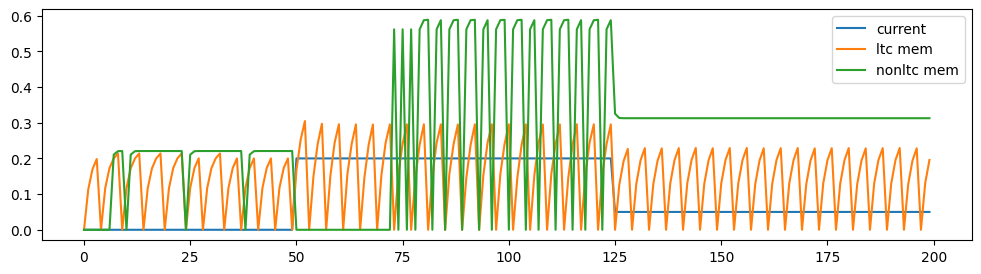

In [158]:
# plot mem and current
fig = plt.figure(figsize=(12, 3))
plt.plot(T, current[:, 0], label='current')
plt.plot(T, LTC_mems[:, 9].numpy(), label='ltc mem')
plt.plot(T, nonLTC_mems[:, 9], label='nonltc mem')
plt.legend()
plt.show()

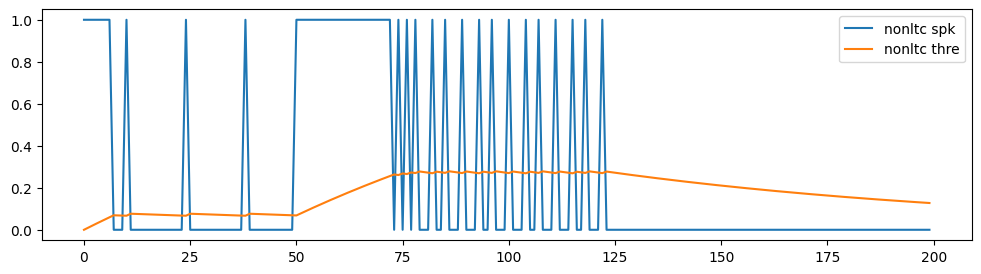

In [160]:
# plot spike
# plt.plot(T, current[:, 0], label='current')
fig = plt.figure(figsize=(12, 3))
plt.plot(T, nonLTC_spks[:, 9], label='nonltc spk')
plt.plot(T, nonLTC_thre[:, 9], label='nonltc thre')

plt.legend()
plt.show()

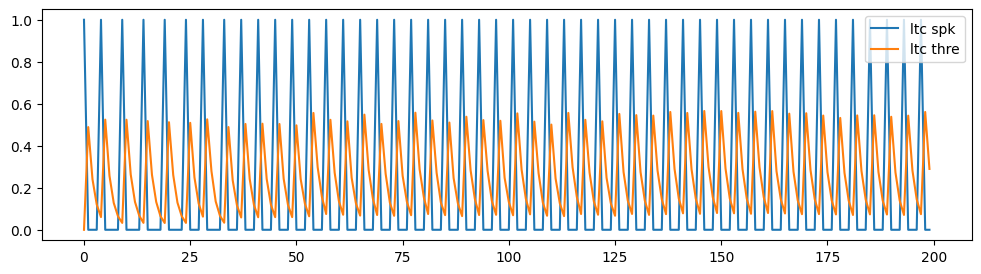

In [161]:
# plot threshold change
# plt.plot(T, current[:, 0], label='current')
fig = plt.figure(figsize=(12, 3))
plt.plot(T, LTC_spks[:, 9].numpy(), label='ltc spk')
plt.plot(T, LTC_thre[:, 9].numpy(), label='ltc thre')
plt.legend()
plt.show()